In [13]:
import pandas as pd
import numpy as np
train = pd.read_csv('/SharedHDD/Code/ML/Recidivism Project/NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
train = train[(train['Recidivism_Arrest_Year1']==False) & (train['Recidivism_Arrest_Year2']==False)]
test = pd.read_csv('/SharedHDD/Code/ML/Recidivism Project/NIJ_s_Recidivism_Challenge_Test_Dataset3.csv')
train  = pd.concat([train[test.columns], train['Recidivism_Arrest_Year3']], axis =1)
train = pd.concat([train,test]).reset_index(drop=True)


for i in train.columns:
    if train[i].dtypes == 'object':
        train[i] = train[i].astype(str).str.replace(' or more', '').replace('nan', np.nan)


int_variables = ['Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',\
'Prior_Arrest_Episodes_Drug', 'Prior_Arrest_Episodes_PPViolationCharges', 'Prior_Conviction_Episodes_Felony',\
'Prior_Conviction_Episodes_Misd', 'Prior_Conviction_Episodes_Prop', 'Prior_Conviction_Episodes_Drug', 'Delinquency_Reports',\
                'Program_Attendances', 'Program_UnexcusedAbsences','Residence_Changes', 'Dependents']
for i in int_variables:
    train[i] = train[i].astype('int')
    
bool_variables = [i for i in train.columns if train[i].dtypes == 'bool']


from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
nan_variables = ['Gang_Affiliated', 'Supervision_Risk_Score_First', 'Supervision_Level_First', 'Prison_Offense', \
                 'Recidivism_Arrest_Year3', 'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive','DrugTests_Cocaine_Positive', \
                 'DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year']
cat_var = ['Gender', 'Race']


one_hot_variables = ['Age_at_Release','Residence_PUMA', 'Education_Level' , 'Prison_Years']

In [14]:
train[(train['Recidivism_Arrest_Year2']==True) & (train['Recidivism_Arrest_Year3']==True)]

KeyError: 'Recidivism_Arrest_Year2'

In [15]:
train['Residence_PUMA'] = train['Residence_PUMA'].astype('str')

dummies = pd.get_dummies(train[one_hot_variables])

train = train.drop(one_hot_variables, axis = 1)
train = pd.concat([train,dummies], axis=1)

for i in cat_var + bool_variables:
    train[i] = labelencoder.fit_transform(train[i])

for i in nan_variables:
    train[nan_variables] = train[nan_variables].replace('nan', np.nan)

original = train[nan_variables]
mask = train[nan_variables].isnull()

for i in nan_variables:
    if train[i].dtypes == 'object':
        train[i] = labelencoder.fit_transform(train[i].astype('str'))

train[nan_variables] = train[nan_variables].where(~mask, original)

train[nan_variables] = train[nan_variables].astype('float')

train['Recidivism_Arrest_Year3'] = train['Recidivism_Arrest_Year3'].astype('float')

In [16]:
feats = [f for f in train.columns if f not in ['Recidivism_Arrest_Year3','ID']]
train[feats] = train[feats].fillna(-1)

train_df = train[train['Recidivism_Arrest_Year3'].notnull()]
test_df = train[train['Recidivism_Arrest_Year3'].isnull()]

X = train_df[feats]
y  = train_df['Recidivism_Arrest_Year3']

In [17]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# define dataset

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=1001)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.668761 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.666877 (0.013715) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.658999 (0.017661) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.666904 (0.013776) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.666946 (0.013880) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.658081 (0.016434) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.666730 (0.013894) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.667269 (0.014707) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.658982 (0.018246) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.667173 (0.014875) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.668761 (0.015949) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.661942 (0.018071) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.667944 (0.017013) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.668047 (0.017705) wit

In [18]:
param_1 = grid_result.best_params_

In [22]:
param_1

{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [52]:
import gc
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
def kfold_rf(X, y, num_folds, best_params):
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['Recidivism_Arrest_Year3','ID']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
        global valid_x
        train_x, train_y = X.iloc[train_idx], y[train_idx]
        valid_x, valid_y = X.iloc[valid_idx], y[valid_idx]
        # LightGBM parameters found by Bayesian optimization
        clf = LogisticRegression(
            **best_params
        )
        clf.fit(train_x, train_y)

        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = abs(clf.coef_[0])
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        gc.collect()
    print('Full F&A score %.6f' % roc_auc_score(train_df['Recidivism_Arrest_Year3'], oof_preds))
    display_importances(feature_importance_df)
    return sub_preds, oof_preds

In [53]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

Full F&A score 0.668382


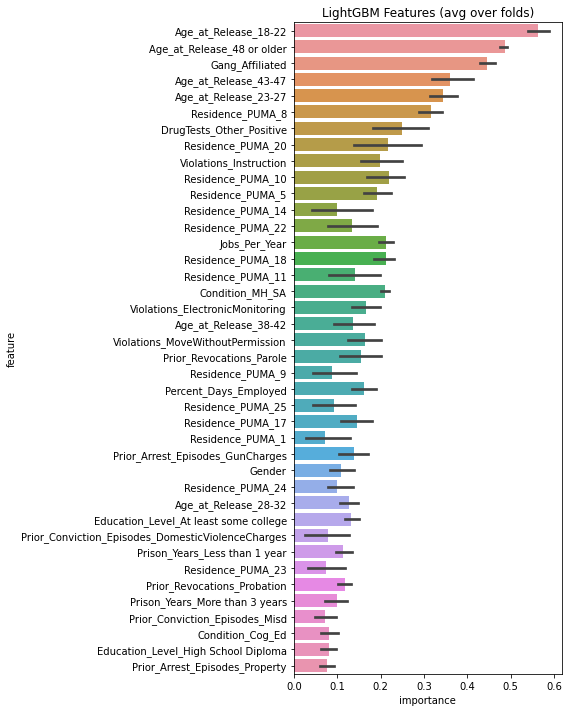

In [54]:
sub_preds, oof_preds = kfold_rf(X,y, 5, param_1)

In [40]:
y

0       0.0
1       1.0
2       0.0
3       1.0
4       0.0
       ... 
9393    0.0
9394    0.0
9395    0.0
9396    0.0
9397    0.0
Name: Recidivism_Arrest_Year3, Length: 9398, dtype: float64

In [42]:
import statsmodels.api as sm
import pandas as pd 
  

   
# building the model and fitting the data
log_reg = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.450387
         Iterations 6


LinAlgError: Singular matrix

/home/student/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


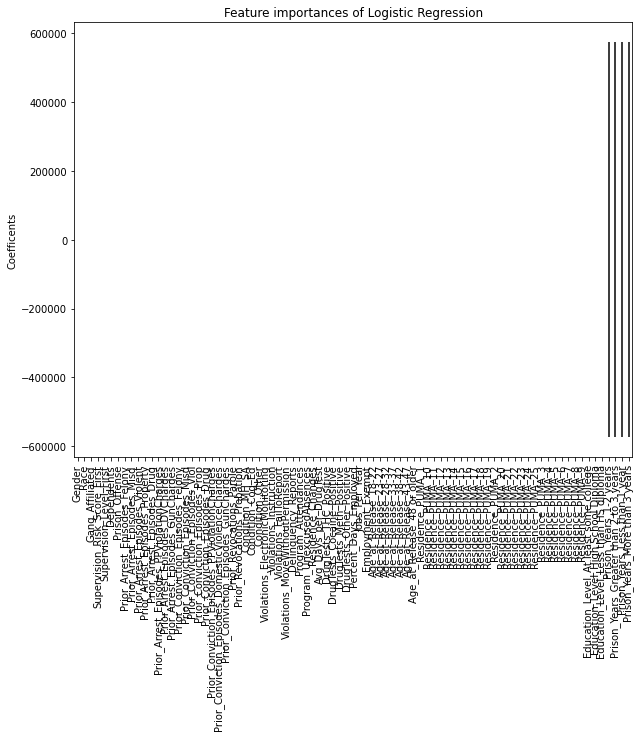

In [38]:
clf = LogisticRegression(**param_1)
clf.fit(X,y)
predProbs = clf.predict_proba(X)

# Design matrix -- add column of 1's at the beginning of your X_train matrix
X_design = np.hstack([np.ones((X.shape[0], 1)), X])

# Initiate matrix of 0's, fill diagonal with each predicted observation's variance
V = np.diagflat(np.product(predProbs, axis=1))

# Covariance matrix
# Note that the @-operater does matrix multiplication in Python 3.5+, so if you're running
# Python 3.5+, you can replace the covLogit-line below with the more readable:
# covLogit = np.linalg.inv(X_design.T @ V @ X_design)
covLogit = np.linalg.inv(np.dot(np.dot(X_design.T, V), X_design))

# Standard errors
std = np.sqrt(np.diag(covLogit))


fig, ax = plt.subplots(figsize = (10,8))
importance = clf.coef_[0]
log_importances = pd.Series(importance, index=X.columns)
log_importances.plot.bar(yerr=std[1:], ax=ax)
ax.set_title("Feature importances of Logistic Regression")
ax.set_ylabel("Coefficents")

plt.xticks(rotation=90)
plt.show()

fig.tight_layout()

In [47]:
importance

array([-0.11958345, -0.00809914,  0.45333162,  0.01644715, -0.06212129,
        0.04442138,  0.03727562,  0.03759529,  0.05177534,  0.0143891 ,
        0.07594823,  0.00153699,  0.04953048, -0.02781748,  0.14213131,
        0.00360982,  0.0713762 ,  0.03230133, -0.01697844,  0.04493188,
       -0.06246618, -0.03536601, -0.03693017,  0.16096112, -0.11856007,
        0.2116798 , -0.08163791, -0.03250465,  0.17306188,  0.20162642,
        0.0008932 ,  0.16637908,  0.00548294, -0.00200381,  0.05313224,
        0.01988994,  0.00111125,  0.03976765, -0.02546334,  0.05854606,
       -0.28636859, -0.16558573,  0.21494265,  0.04274502,  0.58180553,
        0.35260106,  0.12903003, -0.05441871, -0.14230806, -0.36782083,
       -0.49888978, -0.04387547,  0.22984111,  0.14990077,  0.06061503,
       -0.00144612, -0.08721304, -0.01969277, -0.03581071,  0.1474449 ,
       -0.2210495 ,  0.0629237 , -0.04796326,  0.2236477 ,  0.02068616,
        0.14183704, -0.07342441,  0.10586925, -0.09476249, -0.02

In [48]:
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = X.columns
fold_importance_df["importance"] = importance
        #fold_importance_df["fold"] = n_fold + 1
        #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

In [51]:
fold_importance_df['importance'] = abs(fold_importance_df['importance'])

In [54]:
lg_train = pd.DataFrame(data={
    "lg": oof_preds.tolist()
})
lg_test = pd.DataFrame(data={
    "lg": sub_preds.tolist()
})

In [55]:
lg_train.to_csv('lg_train.csv', index = False)
lg_test.to_csv('lg_test.csv', index = False)